In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/preproc')

In [ ]:
from tensorflow import keras
from imutils import paths
import tensorflow as tf
import imageio
import cv2
import os
import matplotlib
%matplotlib
from imutils import paths
import shutil
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import GRU, LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
import tensorflow as tf
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Reshape, Lambda
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam

Using matplotlib backend: agg


In [ ]:
MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048
ORIG_INPUT_DATASET = "/content/drive/MyDrive/final data 7800"
BASE_PATH = "/content/drive/MyDrive/Mini project/dataset"

#define the names of training, validation and testing for directions
TRAIN = "train"
TEST = "test"
VAL = "validation"

CLASSES = ["Violence", "Non_violence"]

BATCH_SIZE = 30

# initialize the label encoder file path and the output directory to
# where the extracted features (in CSV file format) will be stored
LE_PATH = os.path.sep.join(["/content/drive/MyDrive/Mini project/output", "le1.cpickle"])
BASE_CSV_PATH = "/content/drive/MyDrive/Mini project/output"

# set the path to the serialized model after training
MODEL_PATH = os.path.sep.join(["/content/drive/MyDrive/Mini project/output", "final_111V_pg3.model"])

# define the path to the output training history plots
UNFROZEN_PLOT_PATH = os.path.sep.join(["/content/drive/MyDrive/Mini project/output", "final_111unfrozen.png"])
WARMUP_PLOT_PATH = os.path.sep.join(["/content/drive/MyDrive/Mini project/output", "final_111warmup.png"])

In [ ]:
def plot_training(H, N, plotPath):
	# construct a plot that plots and saves the training history
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
	plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
	plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
	plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
	plt.title("Training Loss and Accuracy")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss/Accuracy")
	plt.legend(loc="lower left")
	plt.savefig(plotPath)

In [ ]:
# derive the paths to the training, validation, and testing
# directories
trainPath = os.path.sep.join([BASE_PATH, TRAIN])
valPath = os.path.sep.join([BASE_PATH, VAL])
testPath = os.path.sep.join([BASE_PATH, TEST])
# determine the total number of image paths in training, validation,
# and testing directories
totalTrain = len(list(paths.list_images(trainPath)))
totalVal = len(list(paths.list_images(valPath)))
totalTest = len(list(paths.list_images(testPath)))
print(totalTrain, totalVal, totalTest)

6000 900 900


In [ ]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator(
	rotation_range=30,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")
# initialize the validation/testing data augmentation object (which
# we'll be adding mean subtraction to)
valAug = ImageDataGenerator()
# define the ImageNet mean subtraction (in RGB order) and set the
# the mean subtraction value for each of the data augmentation
# objects
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean

In [ ]:
# initialize the training generator
trainGen = trainAug.flow_from_directory(
    trainPath,
    class_mode="categorical",
    target_size=(224, 224),
    color_mode="rgb",
    shuffle=True,
    batch_size=BATCH_SIZE)
# initialize the validation generator
valGen = valAug.flow_from_directory(
    valPath,
    class_mode="categorical",
    target_size=(224, 224),
    color_mode="rgb",
    shuffle=False,
    batch_size=BATCH_SIZE)
# initialize the testing generator
testGen = valAug.flow_from_directory(
    testPath,
    class_mode="categorical",
    target_size=(224, 224),
    color_mode="rgb",
    shuffle=False,
    batch_size=BATCH_SIZE)

Found 6000 images belonging to 2 classes.
Found 900 images belonging to 2 classes.
Found 900 images belonging to 2 classes.


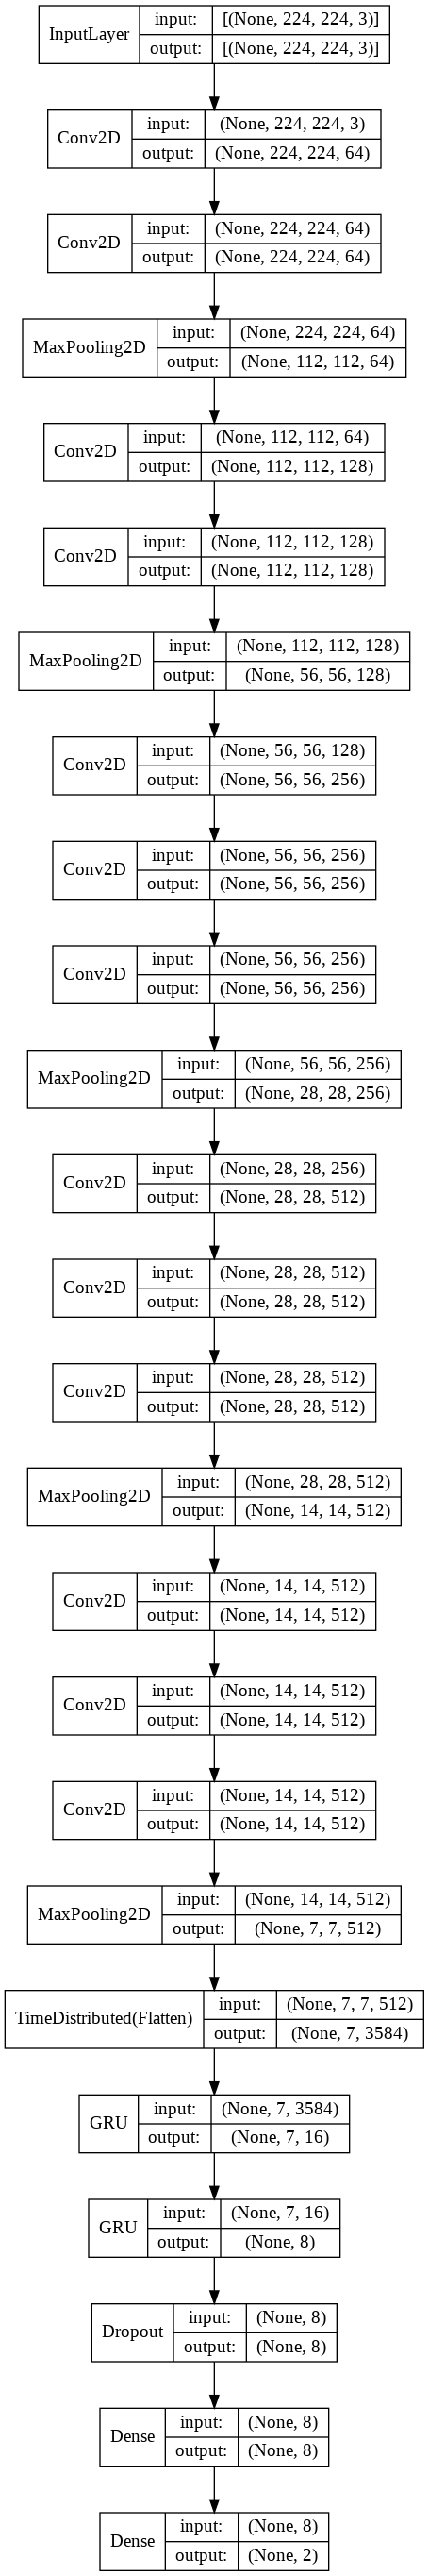

In [ ]:
inp = Input(shape=(224,224,3))
vgg_16 = VGG16(include_top=False, weights='imagenet', input_tensor=inp)
x = vgg_16.output

#Really depends on whether you want pre-trained values to be fixed or not
for layer in vgg_16.layers:
    layer.trainable = False 

#Add here whatever dense layers you need
x = TimeDistributed(Flatten())(x)
x = keras.layers.GRU(16, return_sequences=True)(x)
x = keras.layers.GRU(8)(x)
x = keras.layers.Dropout(0.4)(x)
x = keras.layers.Dense(8, activation="relu")(x)
predictions = keras.layers.Dense(len(CLASSES), activation="softmax")(x)
#x = LSTM(256, return_sequences=False, dropout=0.5)(x)
#predictions = Dense(2, name="dense", activation="softmax")(x)

my_model = Model(inputs=vgg_16.inputs, outputs=predictions)
my_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

from tensorflow.keras import utils
utils.plot_model(my_model, show_shapes=True, show_layer_names=False)

In [ ]:
print("[INFO] training head...")
H = my_model.fit(
	x=trainGen,
	steps_per_epoch=totalTrain // BATCH_SIZE,
	validation_data=valGen,
	validation_steps=totalVal // BATCH_SIZE,
	epochs=15)

[INFO] training head...
Epoch 1/15
200/200 [==============================] - 2053s 10s/step - loss: 0.5515 - accuracy: 0.7075 - val_loss: 0.4452 - val_accuracy: 0.9022
Epoch 2/15
200/200 [==============================] - 102s 508ms/step - loss: 0.3297 - accuracy: 0.9268 - val_loss: 0.2496 - val_accuracy: 0.9256
Epoch 3/15
200/200 [==============================] - 103s 517ms/step - loss: 0.1900 - accuracy: 0.9498 - val_loss: 0.2032 - val_accuracy: 0.9367
Epoch 4/15
200/200 [==============================] - 105s 523ms/step - loss: 0.1359 - accuracy: 0.9615 - val_loss: 0.2352 - val_accuracy: 0.9222
Epoch 5/15
200/200 [==============================] - 104s 521ms/step - loss: 0.1347 - accuracy: 0.9625 - val_loss: 0.2333 - val_accuracy: 0.9222
Epoch 6/15
200/200 [==============================] - 105s 527ms/step - loss: 0.1155 - accuracy: 0.9660 - val_loss: 0.1379 - val_accuracy: 0.9533
Epoch 7/15
200/200 [==============================] - 104s 519ms/step - loss: 0.1117 - accuracy: 0.96

In [ ]:
# reset the testing generator and evaluate the network after
# fine-tuning just the network head
print("[INFO] evaluating after VGG16 with GRU...")
testGen.reset()
predIdxs = my_model.predict(x=testGen,
	steps=(totalTest // BATCH_SIZE) + 1)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testGen.classes, predIdxs,
	target_names=testGen.class_indices.keys()))
plot_training(H, 15, WARMUP_PLOT_PATH)

[INFO] evaluating after VGG16 with GRU...
              precision    recall  f1-score   support

Non_violence       0.96      0.95      0.96       450
    Violence       0.95      0.96      0.96       450

    accuracy                           0.96       900
   macro avg       0.96      0.96      0.96       900
weighted avg       0.96      0.96      0.96       900



In [ ]:
my_model.save("/content/drive/MyDrive/Mini project/output/Final_vmodel_VGG16+GRU.h5")